# Topological regularization of circle embedding

In this notebook, we show how a topological loss can be combined with a linear embedding procedure, as to regularize the embedding and better reflect the topological---in this case circular---prior. 

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Tracking computation times
import time

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from topembed import DiagramFeature

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Ordinary PCA embedding
from sklearn.decomposition import PCA

%matplotlib inline

ImportError: /home/robin/anaconda3/envs/toplayer/lib/python3.8/site-packages/topologylayer/functional/persistence.cpython-38-x86_64-linux-gnu.so: undefined symbol: _ZTIN3c1021AutogradMetaInterfaceE

## Construct data and view restriction to first two coordinates

We now construct a high-dimensional data set sampled from a circular model. The model occurs only in the first two dimensions, and the high-dimensionality of the data is directly caused by random noise.

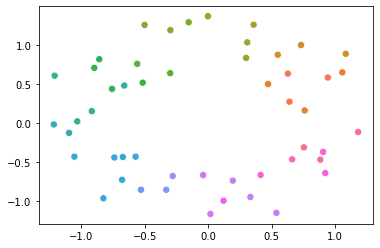

In [2]:
# Seed for reproducibility
np.random.seed(420)

# Sample parameters
npoints = 50 # number of points
ndim = 500 # data dimensionality (with noise)
sigma = 0.4 # magnitude of noise per dimension

# Sample data
t = np.random.uniform(low=0, high=2 * np.pi, size=npoints)
X = np.concatenate([np.transpose(np.array([np.cos(t), np.sin(t)])), np.zeros([npoints, ndim - 2])], axis=1)
N = np.random.uniform(low=-sigma, high=sigma, size=[npoints, ndim])
data = X + N

# Plot the first two dimensions of the data two illustrate the circular model
fig, ax = plt.subplots()
ax = sns.scatterplot(x=data[:,0], y=data[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

## Conduct ordinary PCA embedding

We now explore how well the ordinary PCA embedding is able to recover the model from our data.

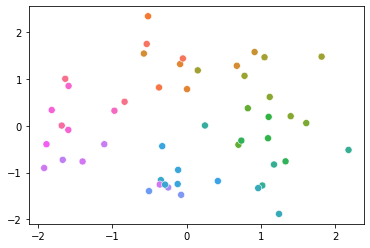

In [3]:
# Conduct PCA embedding
pca = PCA(n_components=2, random_state=42).fit(data)
Y_pca = pca.transform(data)

# View PCA embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_pca[:,0], y=Y_pca[:,1], s=50, hue=t, palette="husl", ax=ax)
ax.get_legend().remove()
plt.show()

We see that due to the noise in high dimensions, while the overall ordering points is good, PCA is no longer able to effectively recover the circular hole. This can be explained by investigating the magnitudes principal components by dimension. We will not include the first two magnitudes for visualization purposes.

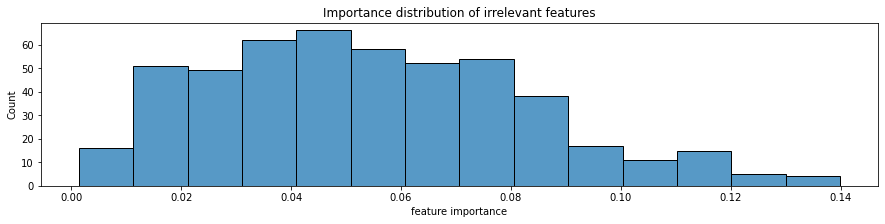

In [4]:
# Compute the magnitudes of the principal components by dimension
magnitudes_pca = pd.DataFrame(np.sum(np.abs(pca.components_[:,2:]), axis=0), columns=["magnitude"])
magnitudes_pca["type"] = "PCA"

# View the magnitudes of the principal components by dimension
fig, ax = plt.subplots(figsize=(15, 3))
sns.histplot(data=magnitudes_pca, x="magnitude", ax=ax)
ax.set_title("Importance distribution of irrelevant features")
ax.set_xlabel("feature importance")
plt.show()

We see that while the principal components agree that the first two dimensions of the data contribute most to the variance, all other dimensions contribute something as well. The noise in each added dimensions results in a small shift of the projection plane from the one spanned by the first two coordinates. These small shifts then accumulate over the many dimensions, until the projection plane no longer reflects the circular model.

## Apply topological regularization to the embedding

We now show how we can bias a linear embedding using a loss function that captures our topological prior.

The model we will use for this learns a linear transformation $W$, which is optimized for the following three losses:
- the reconstruction loss between our data and its $X$ low-rank approximation $XWW^T$;
- a loss function encouraging orthonormality of $W$, i.e., such that  $WW^T$ is a projection matrix;
- a loss function that captures our topological prior.

In [5]:
def TPCA(X, dim, top_criterion, lambda_W=1e4, num_epochs=2000, learning_rate=1e-3, eps=1e-07, random_state=None):
    
    # Center the data
    X = X - X.mean(axis=1, keepdims=True)
    
    # Initialize the linear embedding with PCA
    W = PCA(n_components=dim, random_state=random_state).fit(X).components_.transpose()
    W = torch.tensor(W).type(torch.float)
    W = torch.autograd.Variable(W, requires_grad=True)    
    
    # Initialize the optimization
    if not random_state is None:
        torch.manual_seed(random_state)
    
    X = torch.tensor(X).type(torch.float)  
    optimizer = torch.optim.Adam([W], lr=learning_rate, eps=eps)
    MSE = nn.MSELoss()
    
    # Conduct the optimization
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        P = torch.matmul(X, W) # projection of X onto subspace W
        L = torch.matmul(P, torch.transpose(W, 0, 1)) # low-rank reconstruction of X
        emb_loss = MSE(L, X) # MSE between X and low-rank reconstruction
        IW = torch.matmul(torch.transpose(W, 0, 1), W) # correlation between projection vectors W
        W_loss = lambda_W * torch.norm((IW - torch.eye(2))) # loss to encourage orthonormality of W
        top_loss = top_criterion(P) # topological loss
        loss = emb_loss + W_loss + top_loss
        loss.backward()
        optimizer.step()
        
        if epoch == 0 or (epoch + 1) % (int(num_epochs / 10)) == 0:
            print ("[epoch %d] [embedding loss: %f, orthonormality loss: %f, top loss: %f]" % 
                   (epoch + 1, emb_loss, W_loss, top_loss))
    
    W = W.detach().numpy() # optimized subspace for projection
    Y = np.dot(X.numpy(), W) # data projection onto W
    
    return(Y, W)

As a topological loss, we will use the persistence of the most prominent cycle in our embedding. It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [6]:
# Define topological optimization

def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
top_layer = AlphaLayer(maxdim=1) # alpha complex layer
circular_persistence = DiagramFeature(dim=1, j=1, g=g) # compute persistence of most prominent cycle
lambda_top = -1e1 # scalar factor that trades off embedding and topological loss

# Construct topological loss criterion

def top_criterion(output):
    
    dgminfo = top_layer(output)
    loss = lambda_top * circular_persistence(dgminfo)
    
    return loss

We can now conduct the topologically regularized linear embedding as follows.

[epoch 1] [embedding loss: 0.050847, orthonormality loss: 0.001352, top loss: -4.089754]
[epoch 200] [embedding loss: 0.051712, orthonormality loss: 425.139771, top loss: -11.704611]
[epoch 400] [embedding loss: 0.051878, orthonormality loss: 149.078705, top loss: -13.078013]
[epoch 600] [embedding loss: 0.052055, orthonormality loss: 220.213577, top loss: -10.576378]
[epoch 800] [embedding loss: 0.052223, orthonormality loss: 60.521328, top loss: -12.131926]
[epoch 1000] [embedding loss: 0.052342, orthonormality loss: 70.862442, top loss: -12.939448]
[epoch 1200] [embedding loss: 0.052456, orthonormality loss: 65.639534, top loss: -13.397543]
[epoch 1400] [embedding loss: 0.052525, orthonormality loss: 65.424614, top loss: -12.345023]
[epoch 1600] [embedding loss: 0.052644, orthonormality loss: 69.067070, top loss: -11.441970]
[epoch 1800] [embedding loss: 0.052648, orthonormality loss: 49.101402, top loss: -12.651056]
[epoch 2000] [embedding loss: 0.052697, orthonormality loss: 50.61

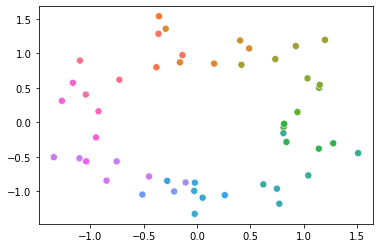

In [7]:
# Conduct topological optimization
num_epochs = 2000
learning_rate = 1e-2

start_time = time.time()
Y_top, W = TPCA(data, 2, top_criterion, num_epochs=num_epochs, learning_rate=learning_rate, random_state=42)
elapsed_time = time.time() - start_time
print("Time for embedding: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

# View topologically regularized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_top[:,0], y=Y_top[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

Finally, we compare the magnitudes of the new projection weights with those from the ordinary PCA embedding.

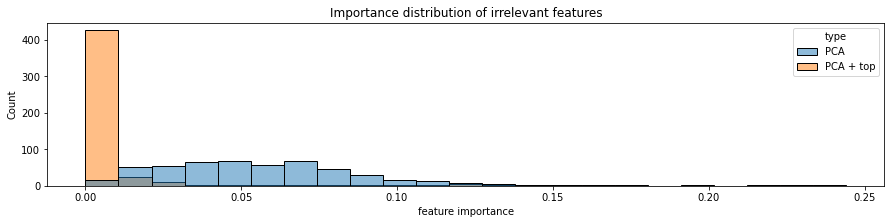

In [8]:
# Compute the magnitudes of the weights by dimension
magnitudes_top = pd.DataFrame(np.sum(np.abs(W[2:,:]), axis=1), columns=["magnitude"])
magnitudes_top["type"] = "PCA + top"

# Combine with the ordinary PCA magnitudes
magnitudes = pd.concat([magnitudes_pca, magnitudes_top], axis=0)

# Compare the magnitudes
fig, ax = plt.subplots(figsize=(15, 3))
sns.histplot(data=magnitudes, x="magnitude", hue="type", ax=ax)
ax.set_title("Importance distribution of irrelevant features")
ax.set_xlabel("feature importance")
plt.show()

We see that by adding a loss for topological regularization, the linear embedding model puts less emphasis on the majority of features that are irrelevant for capturing the topological prior.